# Exam No 4

This is the code for the fourth exam of DS 405 - NLP submitted by Nico Schwarzer, ID: 5632297.

## Loading in packages, models, embeddings and the datasets

In [ ]:
!pip install datasets
!pip install transformers

In [ ]:
!pip install transformers
!pip install sentence-transformers

In [ ]:
import torch
import datasets
from datasets import load_dataset
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from gensim.models import KeyedVectors
from sentence_transformers.util import cos_sim
from sentence_transformers import CrossEncoder
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses


In [ ]:
from sentence_transformers import models

In [ ]:
## mounting google drive

from google.colab import drive

drive.mount('/content/drive')

Now I shall read in the dataset


In [ ]:
dataset_electronics = load_dataset("subjqa", "electronics", cache_dir= '/content/drive/My Drive/DS405B_NLP/dataset_electronics.csv')

Reusing dataset subjqa (/content/drive/My Drive/DS405B_NLP/dataset_electronics.csv/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset_electronics_train = dataset_electronics['train']
dataset_electronics_test = dataset_electronics['test']
dataset_electronics_val = dataset_electronics['validation']


Now, I shall determine if there are cases in the sets with more than one answer or no answer at all since this will influence the reader metrics and the creation of the Dataoader for fine tuning the Reader Model. 

In [ ]:
len_answers_train = [len(dataset_electronics_train["answers"][i]["text"]) for i in range(dataset_electronics_train.shape[0])  ]
len_answers_test = [len(dataset_electronics_test["answers"][i]["text"]) for i in range(dataset_electronics_test.shape[0])  ]
len_answers_val = [len(dataset_electronics_val["answers"][i]["text"]) for i in range(dataset_electronics_val.shape[0])  ]



In [ ]:
pd.Series(len_answers_train).value_counts()

0    784
1    264
2    246
4      1
dtype: int64

In [ ]:
pd.Series(len_answers_test).value_counts()

0    198
2     97
1     63
dtype: int64

In [ ]:
pd.Series(len_answers_val).value_counts()

0    157
1     98
dtype: int64

There are cases with no answer as well as cases with 2 answers. This shall be considered in the following tasks.

## Task 1)

I shall set up the Bi-Encoder Model and encode all contexts and store the contexts together with their embeddings in seperate DFs and save themn to my Drive.

In [ ]:
model_bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

device = torch.device("cuda")
model_bi_encoder = model_bi_encoder.to(device)

For all 3 sets, a DF containing the embeddings in the first 384 columns and the context in the 385th column will be created and stored on the drive. 

In [ ]:
# for the train dataset 

contexts_train = dataset_electronics_train['context']
embeddings_context_train = model_bi_encoder.encode(contexts_train)


embeddings_context_train = pd.DataFrame(embeddings_context_train)
embeddings_context_train["context"] =  contexts_train


# saving on drive

embeddings_context_train.to_csv('/content/drive/My Drive/DS405B_NLP/embeddings_context_train.csv')


In [ ]:
# for the test dataset 

contexts_test = dataset_electronics_test['context']
embeddings_context_test = model_bi_encoder.encode(contexts_test)


embeddings_context_test = pd.DataFrame(embeddings_context_test)
embeddings_context_test["context"] =  contexts_test

# saving on drive
embeddings_context_test.to_csv('/content/drive/My Drive/DS405B_NLP/embeddings_context_test.csv')


In [ ]:
# for the validation dataset 

contexts_val = dataset_electronics_val['context']
embeddings_context_val = model_bi_encoder.encode(contexts_val)


embeddings_context_val = pd.DataFrame(embeddings_context_val)
embeddings_context_val["context"] =  contexts_val


# saving on drive
embeddings_context_val.to_csv('/content/drive/My Drive/DS405B_NLP/embeddings_context_val.csv')


## Task 2)

Next, I shall fine-tune the Cross Encoder on the Train Set. The number of attention heads and the dropout Probability in the Attention Layers  will be used for a HyperParam Tuning. 

The model that performms best on the Validation is is chosen. I measure performace with the recall. If, per question, the correct context is within the top K contexts returned by the Cross-Encoder, then this will be treated as "correct". I shall use K = 10!

Also, importantly, I shall create new sentence query pairs so that the label is not always = 1 in the training data. For each query, a pair containing the corresponding context as well as 3 pairs containing non-corresponding contexts
shall be passed to the DataLoader. This is done since the CrossEncoder does not support the MRN Loss, which would do something similar.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [ ]:
import random as rand

In [ ]:
def collating(batch):

  input_ids = []
  masks = []
  type_ids = []
  labels = []

  # preparing the training 

  for i in range(len(batch)):

    encoding = tokenizer(  batch[i]["question"], batch[i]["context"],   pad_to_max_length = True, truncation=True, return_tensors="pt", max_length = 512)

    input_ = encoding['input_ids']
    token_ = encoding['token_type_ids']
    attention_ = encoding['attention_mask']

    input_ids.append(input_) #.unsqueeze(0))
    masks.append(input_)   #unsqueeze(0))
    type_ids.append(input_)  #.unsqueeze(0))

    if batch[i]["answers"]["text"] == []:
      labels.append(0)
    else:
      labels.append(1)

    ##### 3 other examples of non-correspondong queries and texts to avoid having mainly positive examples

    # other examples 
    all_indices = list(range(len(batch) ))

      #  dropping current index since that query-context pair is already present
    all_indices.pop(i)

      # selecting 3
    rand.shuffle(all_indices)
    random_3 = all_indices[:3]

    for j in range(3):
      encoding = tokenizer(  batch[i]["question"], batch[j]["context"],   pad_to_max_length = True, truncation=True, return_tensors="pt", max_length = 512)

      input_ = encoding['input_ids']
      token_ = encoding['token_type_ids']
      attention_ = encoding['attention_mask']

      input_ids.append(input_) #.unsqueeze(0))
      masks.append(input_)   #unsqueeze(0))
      type_ids.append(input_)  #.unsqueeze(0))
      labels.append(0)


  input_ids = torch.cat(input_ids, dim = 0)
  masks = torch.cat(masks, dim = 0)
  type_ids = torch.cat(type_ids, dim = 0)
  labels = torch.tensor(labels, dtype=torch.float32)

  return input_ids, masks, type_ids, labels
  

In [ ]:
loader_train = DataLoader(dataset_electronics_train, batch_size = 12, shuffle = True, collate_fn = collating)

loader_val = DataLoader(dataset_electronics_val, batch_size = 12, shuffle = True, collate_fn = collating)




In [ ]:
att_drop = [0.8, 0.1, 1.2]
heads = [10,12,14]


In [ ]:
result_matrix = np.ones([9,8])

I shall use the BCEwithLogits Loss since the Problem at hand is a Classification Problem.



 and the final layer is the model is a mere linear Layer with no activation (e the outputs (i.e. logits) of the model are continuous, and  quite frequently are above 1 or below 0. Also, calling ?model shows one that the final layer is a mere linear "regression" layer which can also be seen when just calling 'model' and analyzing the architecture.

The problem at hand is a Classification Problem, so the BCEwithLogits Loss is chosen.That is why this loss is chosen here.



ODER doch besser anderes Tarining ??

In [ ]:
i = 0

for a in att_drop:
  for h in heads:
    
    #print(f"Starting with combination of {a} as Dropout Prob in he Attention Layer and {h} as the Number of Attention Heads !")

    model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")
    
    # setting hyper-params
    model.config.attention_probs_dropout_prob = a
    model.config.num_attention_heads = h

    # to CUDA
    device = torch.device("cuda")
    model = model.to(device)

    # freezing layers
    for param in model.bert.parameters():
      param.requires_grad = False

    for param in model.bert.pooler.parameters():
      param.requires_grad = True

    for param in model.classifier.parameters():
      param.requires_grad = True


    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4) # I have found a LR of 1e-4 to be working well here!

    for epoch in range(8):

      model.train()
      batch_loss = []
      for batch in loader_train:

        optimizer.zero_grad()

        # getting all data for input to reader model!
        ids = batch[0].to(device)
        mask = batch[2].to(device)
        labels = batch[3].to(device)

        outs = model(input_ids = ids, attention_mask = mask, labels = labels)

        #out_logits = outs["logits"].squeeze(1) ##
        loss = outs.loss
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())


      model.eval()
      batch_loss_val = []
      with torch.no_grad():

        for batch in loader_val:

          # getting all data for input to reader model!
          ids = batch[0].to(device)
          mask = batch[2].to(device)
          labels = batch[3].to(device)

          outs = model(input_ids = ids, attention_mask = mask, labels = labels)

          loss = outs.loss

          batch_loss_val.append(loss.item())   


      loss_this_epoch_train = np.mean(batch_loss)
      loss_this_epoch_val = np.mean(batch_loss_val)
    
      #print(f"Epoch :  {epoch} , Training Loss : {loss_this_epoch_train} !")
      #print(f"Epoch :  {epoch} ,Validation Loss : {loss_this_epoch_val} !")

      result_matrix[i,epoch] = loss_this_epoch_val

    i+=1


Since the losses decrease greatly within the first two epochs, I shall plot the validaiton losses from epoch 3 onwards to obtain a more fine-grained picture.

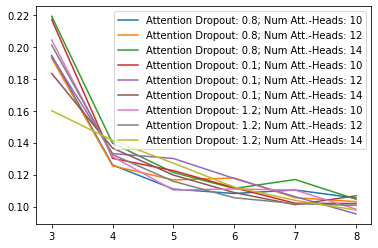

In [ ]:
## Plotting outputs 
import matplotlib.pyplot as plt

epochs = list(range(3,9))

plt.plot(epochs, result_matrix[0,2:])
plt.plot(epochs, result_matrix[1,2:])
plt.plot(epochs, result_matrix[2,2:])
plt.plot(epochs, result_matrix[3,2:])
plt.plot(epochs, result_matrix[4,2:])
plt.plot(epochs, result_matrix[5,2:])
plt.plot(epochs, result_matrix[6,2:])
plt.plot(epochs, result_matrix[7,2:])
plt.plot(epochs, result_matrix[8,2:])


# adding legend
labels = []

for a in att_drop:
  for b in heads:

    labels.append(str("Attention Dropout: " + str(a) + "; Num Att.-Heads: " + str(b) ) )

plt.legend(labels, loc='upper right')
plt.show()


The combination of a Dropout in the Attention Layers of 1.2 and 14 Attention Blocks looks promising.

In [ ]:
model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [ ]:
# to CUDA
device = torch.device("cuda")
model = model.to(device)

# freezing layers
for param in model.bert.parameters():
  param.requires_grad = False

for param in model.bert.pooler.parameters():
  param.requires_grad = True

for param in model.classifier.parameters():
  param.requires_grad = True


In [ ]:
model.config.attention_probs_dropout_prob = 1.2
model.config.num_attention_heads = 14


In [ ]:
# calling optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4) # I have found a LR of 1e-3 to be working well here!


In [ ]:
overall_loss_val = []

for epoch in range(40):

  model.train()
  batch_loss = []
  for batch in loader_train:

    optimizer.zero_grad()

    # getting all data for input to reader model!
    ids = batch[0].to(device)
    mask = batch[2].to(device)
    labels = batch[3].to(device)

    outs = model(input_ids = ids, attention_mask = mask, labels = labels)
    #print(outs.loss)

    loss = outs.loss   
    loss.backward()
    optimizer.step()

    batch_loss.append(loss.item())


  model.eval()
  batch_loss_val = []
  with torch.no_grad():

   for batch in loader_val:

      # getting all data for input to reader model!
      ids = batch[0].to(device)
      mask = batch[2].to(device)
      labels = batch[3].to(device)

      outs = model(input_ids = ids, attention_mask = mask, labels = labels)

      loss = outs.loss
      batch_loss_val.append(loss.item())

  loss_this_epoch_train = np.mean(batch_loss)
  loss_this_epoch_val = np.mean(batch_loss_val)

  overall_loss_val.append(loss_this_epoch_val)

  if (np.argmax(overall_loss_val[-3::])  == 2 ):
    break

  print(f"Epoch :  {epoch} , Training Loss : {loss_this_epoch_train} !")
  print(f"Epoch :  {epoch} ,Validation Loss : {loss_this_epoch_val} !")


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch :  0 , Training Loss : 11.5438672458684 !
Epoch :  0 ,Validation Loss : 3.734837141903964 !
Epoch :  1 , Training Loss : 1.988703402656096 !
Epoch :  1 ,Validation Loss : 0.6786860498515043 !
Epoch :  2 , Training Loss : 0.4862809515109769 !
Epoch :  2 ,Validation Loss : 0.20792130296203223 !
Epoch :  3 , Training Loss : 0.2532509161780278 !
Epoch :  3 ,Validation Loss : 0.14208594184707513 !
Epoch :  4 , Training Loss : 0.1828991296114745 !
Epoch :  4 ,Validation Loss : 0.12694903632456606 !
Epoch :  5 , Training Loss : 0.15369306580611952 !
Epoch :  5 ,Validation Loss : 0.11697304130277851 !
Epoch :  6 , Training Loss : 0.14008755209269347 !
Epoch :  6 ,Validation Loss : 0.1031673237342726 !
Epoch :  7 , Training Loss : 0.12446268247785391 !
Epoch :  7 ,Validation Loss : 0.09815940878946673 !
Epoch :  8 , Training Loss : 0.12195549729383653 !
Epoch :  8 ,Validation Loss : 0.0939256746999242 !
Epoch :  9 , Training Loss : 0.1109266974100912 !
Epoch :  9 ,Validation Loss : 0.0918

In [ ]:
#saving the model 
model_save_name = 'exam_4_model_ex2_best.pth'
path = F"/content/drive/My Drive/DS405B_NLP/{model_save_name}" 
torch.save(model, path)


## Task 3)

In Task 3, I shall retrieve the 10 most similar contexts for each test-query!
To that aim, the embeddings of the test set are re-used. Each query shall then be encoded and the assosiated 10 most similar contexts shall be retrieved. Next, the cross-encoder shall re-oorder these 10 contexts per query!

The final results shall  be stored in a matrix. 

As has been discussed in the lecture, for the recall, only answerable questions shall be considered.


In [ ]:
from sentence_transformers.util import cos_sim
import pandas as pd
import numpy as np

In [ ]:
embeddings_context_test = pd.read_csv("/content/drive/My Drive/DS405B_NLP/embeddings_context_test.csv")


In [ ]:
# only the embeddings, not the context
embeddings_test = np.array(embeddings_context_test.iloc[:,1:385]) # since 0 is an index added by pandas


In [ ]:
# matrix for sotring ideces of 10 most similar embeddings to each query 

similar_embeddings = np.ones([dataset_electronics_test.shape[0] , 10])


### With Method 1

As has been discussed in the lecture, for the recall, only answerable questions shall be considered.

In [ ]:
model = torch.load("/content/drive/My Drive/DS405B_NLP/exam_4_model_ex2_best.pth")


In [ ]:
## tokenizer 
from transformers import AutoTokenizer

model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [ ]:
for i in range(dataset_electronics_test.shape[0]):

  embedding_query = model_bi_encoder.encode(dataset_electronics_test["question"][i])

  # instantiating cos_sim list
  cos_sims = np.ones(dataset_electronics_test.shape[0])

  for j in range(dataset_electronics_test.shape[0]):

    cos_sims[j] =  cos_sim(np.array(embedding_query, dtype = "float64") , np.array(embeddings_test[j,:], dtype = "float64") ) # cos sim of query and embedding of all context embeddings, respectively

  # sorting the cosine similarity and retrieving top 10 indeces (usiing argsort)
  sorted = np.flip(np.argsort(cos_sims))
  sorted_top_10 = sorted[:10]

  # using bi-encoder 
  preds = []

  for idx in sorted_top_10:   
    
    encoding = tokenizer(  dataset_electronics_train[i]["question"], dataset_electronics_train[int(idx)]["context"],   pad_to_max_length = True, truncation=True, return_tensors="pt", max_length = 512)

    ids = encoding['input_ids'].to(device)
    #tokens = encoding['token_type_ids'].to(device)
    masks = encoding['attention_mask'].to(device)

    outs = model(input_ids = ids, attention_mask = masks ) #, labels = labels)
    out_logits = float(outs["logits"].squeeze(1).cpu().detach().numpy() )
    preds.append(out_logits)


  # ordering indexes of predictions (0-9)
  preds_ordered = np.flip(np.argsort(preds))

  # re-arraning the indices of the top 10 most similar contexts based on the ordered pred indices 
  sorted_top_10_re_ordered =  sorted_top_10[preds_ordered]

  # finally: Adding to the similarity_embeddings matrix
  similar_embeddings[i,:] = sorted_top_10_re_ordered


In [ ]:

np.save("/content/drive/My Drive/DS405B_NLP/similar_embeddings.npy", similar_embeddings)

## Task 4

Now, I shall compute the recall kor differekt values of K and asses what an increase of K will cause when considering the recall metric. The recall metric is the overall share of the corresponding context being in the top K most similar contexts after the re-ranking.

The following works since the query and the embedding are indexed by their position.

In [ ]:
similar_embeddings = np.load("/content/drive/My Drive/DS405B_NLP/similar_embeddings.npy")

In [ ]:
k_s = [1,2,3,4,5,6,7,8,9,10]
recalls = []

for k in k_s:

  corrects = 0
  ans_count = 0

  # retrieving only k-most similar contexts per query
  k_embeddings = similar_embeddings[:,:k]


  for i in range(dataset_electronics_test.shape[0]):

    # only answerable questions
    if dataset_electronics_test[i]["answers"]["text"] != []:
    
      # only considering the k-clostest embeddings for each query 
      sim_embeddings =  k_embeddings[i,:]
      correct_index = i

      if i in sim_embeddings:
  
        corrects += 1 
        ans_count += 1

  recall = corrects/ans_count
  
  recalls.append(recall)

  if k in [1,3,5,10]:
    print(f"The recall for k = {k} on the test set is {recall} !")



The recall for k = 1 on the test set is 0.0223463687150838 !
The recall for k = 3 on the test set is 0.0782122905027933 !
The recall for k = 5 on the test set is 0.1340782122905028 !
The recall for k = 10 on the test set is 0.19832402234636873 !


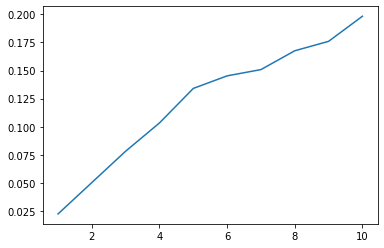

In [ ]:
import matplotlib.pyplot as plt

plt.plot(k_s, recalls) 

While the recall metric rises with a higher K number, the slope is a lot less steep from k=5 upwards. Thus, and in light of a less time-intensive omputation, k=5 seems like a reasonable number for Task 6.

## Task 5)

Now, I shall fit the Reader Model to the training data.

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

model_name = "deepset/minilm-uncased-squad2"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

from transformers import AutoTokenizer

model_name = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)


Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

The preprocessing function is inspired by the Huggingface documentation
(https://huggingface.co/course/chapter7/7?fw=tf).
However, one also needs to account for cases where no answer is provided and where more than one answer is provided!

In [ ]:
def preprocessing(batch):


  input_ids = []
  masks = []
  type_ids = []
  pos_start = []
  pos_end = []

  for data in batch:

    result_tokens = tokenizer(data['question'], 
                                 data['context'], 
                                 return_overflowing_tokens=True, 
                                 max_length = 512, 
                                 stride = 100, return_tensors = "pt", pad_to_max_length = True, return_offsets_mapping = True)

    for i, offset in enumerate(result_tokens["offset_mapping"]): # go through different examples produced by stride
    # i counts, offset indicates at which position that cut-off takes place!
      sequence_ids = result_tokens.sequence_ids(i)

      # find context of this window - also query in window! 
      idx = 0
      while sequence_ids[idx] != 1:
          idx += 1
      context_start = idx

      while sequence_ids[idx] == 1: # now starting at the start position (idx) and adding ones and then removing (zero indexing)
          idx += 1
      context_end = idx - 1

      if data['answers']['answer_start'] == []:  # case wwhere no answer is provided

        input_ids.append(result_tokens['input_ids'][i].unsqueeze(0)     )
        masks.append(result_tokens['attention_mask'][i].unsqueeze(0)    )
        type_ids.append(result_tokens['token_type_ids'][i].unsqueeze(0) )

        pos_start.append(0)
        pos_end.append(0)


      else:
        ## Now important to catch two answers sometimes
        num_answers = len(data['answers']['answer_start'])
                          
        for ans in range(num_answers):

          start_char = data['answers']['answer_start'][ans]
          end_char = data['answers']['answer_start'][ans] + len(data['answers']['text'][ans])

          input_ids.append(result_tokens['input_ids'][i].unsqueeze(0))
          masks.append(result_tokens['attention_mask'][i].unsqueeze(0))
          type_ids.append(result_tokens['token_type_ids'][i].unsqueeze(0))

          # If the answer is not fully inside the context, label is (0, 0)    ## makes sense!     ### context start -> start of the context!
          if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
              pos_start.append(0)
              pos_end.append(0)
          else:
              # Otherwise it's the start and end token positions - makes perfect sense :)
              idx = context_start
              while idx <= context_end and offset[idx][0] <= start_char:
                  idx += 1
              pos_start.append(idx - 1)

              idx = context_end
              while idx >= context_start and offset[idx][1] >= end_char:
                  idx -= 1
              pos_end.append(idx + 1)

  input_ids = torch.cat(input_ids, dim=0)
  masks = torch.cat(masks, dim=0)
  type_ids = torch.cat(type_ids, dim=0)
  pos_start = torch.tensor(pos_start)
  pos_end = torch.tensor(pos_end)

  return input_ids, type_ids, masks, pos_start, pos_end


In [ ]:
train_dataloader = DataLoader(dataset_electronics_train, batch_size = 20, collate_fn = preprocessing, shuffle = True)
val_dataloader = DataLoader(dataset_electronics_val, batch_size = 20, collate_fn = preprocessing , shuffle = False)  # not shuffleing to always get same validation losses


Since training all model parameters causes a RAM crash and likely takes very long, it makes sense to focus on certain parameters. I have found that freezing 
all parameters except the final linear Layer in the last Attention Head delivers rather promising results.

I have also experimented with not freeezing the parameters of the QA Layer and other linear layers, yet this mostly lead to direct overfitting.

I have also found a learning rate of 1e-5 to be working well. The quick overfitting discussed below could not be mitigated by a lower learning rate.

In [ ]:
# hyper-parameters

dropouts = [0.05,0.75,0.1]
num_heads = [10, 12]

I shall now instantiate a matrix to store the results of the validation losses per HyperParam Combination.

In [ ]:
results_param_search = np.ones([6,5])


In [ ]:
num_epochs = 10 

i = 0  # counts from 1-9 to aassign to rows in result matrix 

for drop in dropouts:
  for num in num_heads:
    
    model = AutoModelForQuestionAnswering.from_pretrained(model_name)

    # to CUDA
    device = torch.device("cuda")
    model = model.to(device)


    # setting hyper-params

    model.config.attention_probs_dropout_prob = drop
    model.config.num_attention_heads = num

    # freezing all params except Q&A Params

    for param in model.parameters():
      param.requires_grad = False

    for param in model.bert.encoder.layer[ len(model.bert.encoder.layer) - 1 ].output.parameters():   
      param.requires_grad = True


    # calling optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4) # I have found a LR of 1e-4 to be working well here!

    print(f"Starting woth combination of {drop} Dropout Prob and {num} hidden layers !")


    for epoch in range(num_epochs): 

      batch_loss_train = []
      model.train()
      for batch in train_dataloader:
        optimizer.zero_grad()

        # getting all data for input to reader model!
        ids = batch[0].to(device)
        type_ids = batch[1].to(device)
        masks = batch[2].to(device)
        pos_start = batch[3].to(device)
        pos_end = batch[4].to(device)
        

        outputs = model(input_ids = ids,  token_type_ids = type_ids, attention_mask = masks, start_positions = pos_start, end_positions = pos_end)
        
        outputs.loss.backward()
        optimizer.step()
        batch_loss_train.append(outputs.loss.item())

      model.eval()
      batch_loss_val = []
 
      with torch.no_grad():
        for batch_val in val_dataloader:

          ids = batch[0].to(device)
          type_ids = batch[1].to(device)
          masks = batch[2].to(device)
          pos_start = batch[3].to(device)
          pos_end = batch[4].to(device)
          
          outputs = model(input_ids = ids,  token_type_ids = type_ids, attention_mask = masks, start_positions = pos_start, end_positions = pos_end)
          
          batch_loss_val.append(outputs.loss.item())

      
      # mean losses this epoch:
      epoch_loss_train = np.mean(batch_loss_train)
      epoch_loss_val = np.mean(batch_loss_val)

      # storing the result in a matrix
      results_param_search[i,epoch] = epoch_loss_val

    # increasing i 
    i += 1 


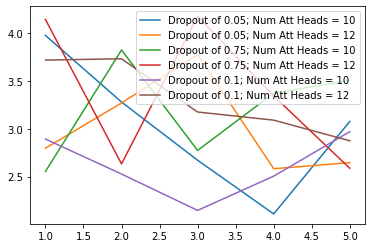

In [ ]:
## Plotting outputs 
import matplotlib.pyplot as plt

epochs = list(range(1,6))

plt.plot(epochs, results_param_search[0,:])
plt.plot(epochs, results_param_search[1,:])
plt.plot(epochs, results_param_search[2,:])
plt.plot(epochs, results_param_search[3,:])
plt.plot(epochs, results_param_search[4,:])
plt.plot(epochs, results_param_search[5,:])

# adding legend
labels = []

for drop in dropouts:
  for num in num_heads:

    labels.append(str("Dropout of " + str(drop) + "; Num Att Heads = " + str(num) ) )

plt.legend(labels, loc='upper right')
plt.show()


It seems that the combination of a dropout of 0.1 and 12 attention can be attributed to a constantly decreasing validation loss. Hence, this model shal be trained for longer using these Hyper-Parameters.

In [ ]:
model_name = "deepset/minilm-uncased-squad2"
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# to CUDA
device = torch.device("cuda")
model = model.to(device)


# setting hyper-params
model.config.attention_probs_dropout_prob = 0.1
model.config.num_attention_heads = 12


In [ ]:

for param in model.parameters():
  param.requires_grad = False

  ####

for param in model.bert.encoder.layer[len(model.bert.encoder.layer) - 2].intermediate.parameters():   
  param.requires_grad = True

for param in model.bert.encoder.layer[len(model.bert.encoder.layer) - 2].output.parameters():   
  param.requires_grad = True

  ####

for param in model.bert.encoder.layer[len(model.bert.encoder.layer) - 1].intermediate.parameters():   
  param.requires_grad = True

for param in model.bert.encoder.layer[len(model.bert.encoder.layer) - 1].output.parameters():   
  param.requires_grad = True

  #### 

for param in model.qa_outputs.parameters():   
  param.requires_grad = True


In [ ]:
 # calling optimizer
 optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4) # I have found a LR of 1e-4 to be working well here!


Again, I have implemented early stopping. Note that at least 30 iterations need to be run in this case. This is due to experimenting and finding that sometimes, the validation loss does not decrease for a few epochs and then starts decreasing again.

In [ ]:
overall_val_loss = []

num_epochs = 60

for epoch in range(num_epochs): 

  model.train()
  la = []
  for batch in train_dataloader:
    optimizer.zero_grad()

    # getting all data for input to reader model!
    ids = batch[0].to(device)
    type_ids = batch[1].to(device)
    masks = batch[2].to(device)
    pos_start = batch[3].to(device)
    pos_end = batch[4].to(device)
    

    outputs = model(input_ids = ids,  token_type_ids = type_ids, attention_mask = masks, start_positions = pos_start, end_positions = pos_end)
    
    outputs.loss.backward()
    optimizer.step()
    la.append(outputs.loss.item())
  
  model.eval()
  
  batch_loss_val = []
  with torch.no_grad():
    for batch_val in val_dataloader:

      ids = batch[0].to(device)
      type_ids = batch[1].to(device)
      masks = batch[2].to(device)
      pos_start = batch[3].to(device)
      pos_end = batch[4].to(device)
      
      outputs = model(input_ids = ids,  token_type_ids = type_ids, attention_mask = masks, start_positions = pos_start, end_positions = pos_end)
      
      batch_loss_val.append(outputs.loss.item())

  
  # mean losses this epoch:
  epoch_loss_val = np.mean(batch_loss_val)
  x = np.mean(la)

  overall_val_loss.append(epoch_loss_val)

  if (len(overall_val_loss) > 30) and  (np.argmax(overall_val_loss[-3::])  == 2 ):
    break


  print(f'epoch {epoch},Validation Loss: {epoch_loss_val}')
  print(f'epoch {epoch},Train: {x}')
  print("----------------------------------")
  

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


epoch 0,Validation Loss: 2.085031032562256
epoch 0,Train: 2.6289299726486206
----------------------------------
epoch 1,Validation Loss: 2.781891345977783
epoch 1,Train: 2.501262002521091
----------------------------------
epoch 2,Validation Loss: 1.7699557542800903
epoch 2,Train: 2.431543423069848
----------------------------------
epoch 3,Validation Loss: 1.7873694896697998
epoch 3,Train: 2.3555471102396646
----------------------------------
epoch 4,Validation Loss: 2.1914243698120117
epoch 4,Train: 2.3585415946112738
----------------------------------
epoch 5,Validation Loss: 1.9197567701339722
epoch 5,Train: 2.299520949522654
----------------------------------
epoch 6,Validation Loss: 2.3665528297424316
epoch 6,Train: 2.285743488205804
----------------------------------
epoch 7,Validation Loss: 2.2225899696350098
epoch 7,Train: 2.2708689239290027
----------------------------------
epoch 8,Validation Loss: 2.133688449859619
epoch 8,Train: 2.214844226837158
--------------------------

In [ ]:
## saving model 

#saving the model 
model_save_name = 'exam_4_model_ex_5_best.pth'
path = F"/content/drive/My Drive/DS405B_NLP/Ex4/{model_save_name}" 
torch.save(model, path)



## Task 6)

Now, I shall consider the k most likely contents (here k = 5) and use the Reader Model on them and the infer the most likely answer. To make thins easier, I shall use a pipeline that includes the trained model and the corresponding tokenizer.

I shall consider both answerable and non-answerable queries.

In [ ]:
reader_model_trained = torch.load("/content/drive/MyDrive/DS405B_NLP/Ex4/exam_4_model_ex_5_best.pth", map_location=torch.device('cpu'))  # needs to be called additionally when not running on GPU


In [ ]:
similar_embeddings = np.load("/content/drive/My Drive/DS405B_NLP/similar_embeddings.npy")


In [ ]:
from transformers import AutoModelForQuestionAnswering,  AutoTokenizer, pipeline

model_name = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)


The metrics shall be calculated as laid out in the Assignment. Again, a precise seperation of the different combinations of potential predicted and ground truth answers and their resspective resulting metrics is needed. Consider thee function below.

In [ ]:
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

def metrics(pred_ans, real_ans):

  ''' This function calculates the metrics for one sample dependent on the number
  of provided ground truth answers'''

  length = len(real_ans)
  EM = 0
  f1 = 0
  
  ### case 0 true answer

  if length == 0:

    if pred_ans == " ":  # in the case of two empty predictions
      EM = 1
    # in this case, also the F1 Score should be one 
      f1 = 1

  ### case 1 true answer 
  if length == 1:

    # controllig for case that predicted answer is empty 
    if pred_ans == " ":
      EM = 0
      f1 = 0
    else:
    
      if pred_ans == real_ans[0]:
        EM = 1

      tokenized_ans = word_tokenize(real_ans[0])
      tokenized_pred = word_tokenize(pred_ans)
      
      # recall - share of tokens of predicted answer within ground truth
      recall = sum(a in tokenized_ans for a in tokenized_pred) / len(tokenized_ans)

      # precision - share of tokens of GT answer within prediction
      precision = sum(a in tokenized_pred for a in tokenized_ans) / len(tokenized_pred)

      # F1
      ## case that both are 0 - will lead to diivision error
      if recall > 0 or precision  > 0:
        f1 = 2* ( precision * recall) / (precision + recall)
      else:
        f1 = 0

  ### case 2 true answers 
  if length == 2:

  # controllig for case that predicted answer is empty 
    if pred_ans == " ":
      EM = 0
      f1 = 0
    else:

      if pred_ans == real_ans[0]:
        EM = 1
      if pred_ans == real_ans[1]:
        EM = 1
        
      tokenized_ans_1 = word_tokenize(real_ans[0])
      tokenized_ans_2 = word_tokenize(real_ans[1])
      tokenized_pred = word_tokenize(pred_ans)
      
      # first possible f1 
      recall_1 = sum(a in tokenized_ans_1 for a in tokenized_pred) / len(tokenized_ans_1)
      precision_1 = sum(a in tokenized_pred for a in tokenized_ans_1) / len(tokenized_pred)
      ## case that both are 0 - will lead to diivision error
      if recall_1 > 0 or precision_1  > 0:
        f1_1 = 2* ( precision_1 * recall_1) / (precision_1 + recall_1)
      else:
        f1_1 = 0

      # second possible f1
      recall_2 = sum(a in tokenized_ans_2 for a in tokenized_pred) / len(tokenized_ans_2)
      precision_2 = sum(a in tokenized_pred for a in tokenized_ans_2) / len(tokenized_pred)
      ## case that both are 0 - will lead to diivision error
      if recall_2 > 0 or precision_2  > 0:
        f1_2 = 2* ( precision_2 * recall_2) / (precision_2 + recall_2)
      else:
        f1_2 = 0

      # selecting bestt F1 
      f1 = np.max([f1_1, f1_2])

  return EM, f1

### Using the Fine-tuned Model

In [ ]:
## setting uo the pipeline 

nlp = pipeline('question-answering', model= reader_model_trained, tokenizer=model_name)


In [ ]:
EMs = []
F1s = []

for i in range(len(dataset_electronics_test)):

  context_ids = similar_embeddings[i,:5]
  answers = []

  for idx in context_ids:
    QA_input = {
      'question': dataset_electronics_test[i]["question"],
      'context': dataset_electronics_test[int(idx)]["context"]
      }
    answers.append(nlp(QA_input))


  best_ans_score = np.argmax([a["score"] for a in answers])

  # appending inputs for metric computation
  if (answers[best_ans_score]["answer"] == '') or  ( (answers[best_ans_score]["start"] == 0 )  and (answers[best_ans_score]["end"] == 1 ) ):
    predicted_answer = " "
  else:
    predicted_answer = answers[best_ans_score]["answer"] 


  real_answer = dataset_electronics_test[i]["answers"]["text"]

  EM_here, f1_here = metrics(predicted_answer, real_answer)

  EMs.append(EM_here)
  F1s.append(f1_here)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
mean_em_tuned = np.mean(EMs)
mean_f1_tuned = np.mean(f1_here)

In [ ]:
print(f"For the fine-tuned model, the EM Score is {mean_em_tuned} ans the F1 Score is {mean_f1_tuned}")

For the fine-tuned model, the EM Score is 0.036312849162011177 ans the F1 Score is 0.36363636363636365


### Benchmark - no Fine Tuning


In [ ]:
## setting uo the pipeline 

nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)


In [ ]:
EMs = []
F1s = []

for i in range(len(dataset_electronics_test)):

  context_ids = similar_embeddings[i,:5]
  answers = []

  for idx in context_ids:
    QA_input = {
      'question': dataset_electronics_test[i]["question"],
      'context': dataset_electronics_test[int(idx)]["context"]
      }
    answers.append(nlp(QA_input))


  best_ans_score = np.argmax([a["score"] for a in answers])

  # appending inputs for metric computation
  if (answers[best_ans_score]["answer"] == '') or  ( (answers[best_ans_score]["start"] == 0 )  and (answers[best_ans_score]["end"] == 1 ) ):
    predicted_answer = " "
  else:
    predicted_answer = answers[best_ans_score]["answer"] 


  real_answer = dataset_electronics_test[i]["answers"]["text"]

  EM_here, f1_here = metrics(predicted_answer, real_answer)

  EMs.append(EM_here)
  F1s.append(f1_here)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
mean_em_base =  np.mean(EMs)
mean_f1_base = np.mean(f1_here)

In [ ]:
print(f"For the non-fine-tuned model, the EM Score is {mean_em_base} and the F1 Score is {mean_f1_base}")

For the non-fine-tuned model, the EM Score is 0.002793296089385475 and the F1 Score is 0.0


As can be seen, the fine-tuning of the reader model has a huge impact on performance. This might be due to the fact that the data under consideration is quite domain-specific. Also, there are some unanswerable questions in the training and testing set, which not only makes the task harder for the fine-tuned reader model, but also for the pre-trained model since it was not fit on such questions.